# Predictive modeling

First, we read the pre-processed training data from csv files.

In [1]:
import pandas as pd
import numpy as np
X_train = pd.read_csv('X_train_sub.csv')
# Somehow, the 'Unnamed: 0' appears when processing the data, we need to get rid of it
X_train.drop(columns='Unnamed: 0', inplace=True) 
y_train = pd.read_csv('y_train_sub.csv')

### Training the Random forest classifier with the training data
We tried different classifiers and parameters, the best results were achieved by Random forest classifier.

In [2]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=8, max_depth=8, random_state=11).fit(X_train, y_train)

### Validating the model
Next, we read the pre-processed validation data from csv files and predict probabilities on this to find out what cutoff levels we should use to decide if the diagnosis would be positive or negative.

In [3]:
X_val = pd.read_csv('X_val.csv')
X_val.drop(columns='Unnamed: 0', inplace=True)
y_val = pd.read_csv('y_val.csv')
y_val = y_val.y

probs = rf.predict_proba(X_val)[1]
assert np.isclose(probs.sum(axis=1), 1).all() # check that all rows sum up to 1

probs = pd.DataFrame(probs, columns=['a', 'b']) # Store in pandas Dataframe with two columns
probs = probs.b # Keep only one column (store as a pandas Series)

probs

0       0.119937
1       0.139965
2       0.018016
3       0.869113
4       0.852608
          ...   
7652    0.120830
7653    0.475774
7654    0.605450
7655    0.545540
7656    0.147768
Name: b, Length: 7657, dtype: float64

We generate the list of possible cutoff levels by step of 0.5 percentage points. Since our validation dataset has 7656 rows, it is not useful to include all the probabilities.

In [4]:
cutoffs = pd.DataFrame({'cutoff':np.arange(0.005,1,0.005)}) 
cutoffs

,cutoff
0,0.005
1,0.010
2,0.015
3,0.020
4,0.025
...,...
194,0.975
195,0.980
196,0.985
197,0.990


Now we calculate false and true positives and negatives for each cutoff level and corresponding accuracy, precision and recall values.

In [5]:
tpr = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut.iloc[0], y_val == 1)) / np.sum(y_val == 1), axis=1)
fpr = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut.iloc[0], y_val == 0)) / np.sum(y_val == 0), axis=1)

stats = pd.DataFrame({'cutoff':cutoffs.cutoff, 'tpr':tpr, 'fpr':fpr})

tp_count = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut.values[0], y_val == 1)), axis=1)
fp_count = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut.values[0], y_val == 0)), axis=1)
tn_count = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs < cut.values[0], y_val == 0)), axis=1)
fn_count = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs < cut.values[0], y_val == 1)), axis=1)

stats['tp_count'] = tp_count
stats['fp_count'] = fp_count
stats['tn_count'] = tn_count
stats['fn_count'] = fn_count
stats['accuracy'] = (stats['tp_count'] + stats['tn_count']) / len(probs)
stats['precision'] = stats['tp_count'] / (stats['tp_count'] + stats['fp_count'])
stats['recall'] = stats['tp_count'] / (stats['tp_count'] + stats['fn_count'])

Find out the cutoffs with highest accuracy and highest precision:

In [6]:
cutoff1 = stats.accuracy.idxmax(axis=0, skipna=True)
print('Max accuracy: ', stats.loc[cutoff1]['accuracy'], 
      ' ( cutoff ', stats.loc[cutoff1]['cutoff'], ', precision ', stats.loc[cutoff1]['precision'], ')\n')

cutoff2 = stats.precision.idxmax(axis=0, skipna=True)
print('Max precision: ', stats.loc[cutoff2]['precision'],
      ' ( cutoff ', stats.loc[cutoff2]['cutoff'], ', accuracy ', stats.loc[cutoff2]['accuracy'], ')\n')


Max accuracy:  0.8974794305863916  ( cutoff  0.5700000000000001 , precision  0.8966333508679643 )

Max precision:  1.0  ( cutoff  0.965 , accuracy  0.5097296591354317 )



Now we can draw the receiver operating characteristic curve (ROC) to illustrate the true positive and negative rates depending on the cutoff level.

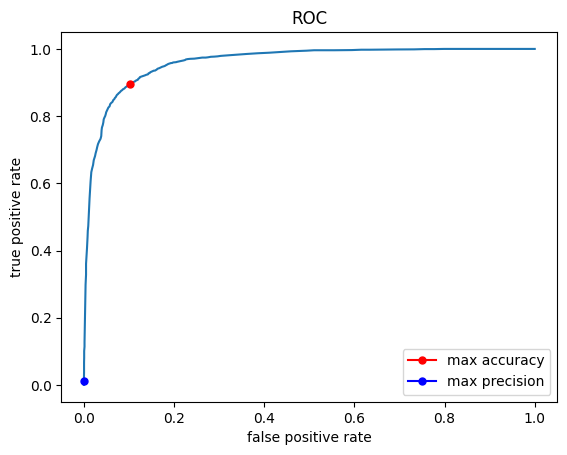

In [7]:
import matplotlib.pyplot as plt
plt.title("ROC")
plt.plot(stats['fpr'], stats['tpr'])
plt.plot(stats.loc[cutoff1]['fpr'], stats.loc[cutoff1]['tpr'], color='red', marker='o', markersize=5, label="max accuracy")
plt.plot(stats.loc[cutoff2]['fpr'], stats.loc[cutoff2]['tpr'], color='blue', marker='o', markersize=5, label="max precision")
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

### Applying the model on Kaggle competition dataset
To test our model on Kaggle competition (*https://www.kaggle.com/competitions/playground-series-s4e11/*), we need to predict the y-values (0 or 1) for the competition test dataset containing 93800 rows.
We drop the name column, as we did in our training dataset.

In [8]:
kaggle_test = pd.read_csv('test_cleaner2.csv')
kaggle_test.drop(columns=['Name'], inplace=True)

Modeling the entire dataset results in a memory error, so we have to split the test data into smaller parts, make the predictions and merge them together again.

In [9]:
kaggle_probs = pd.Series()
for i in range(len(kaggle_test) // 10000 + 1):
    a = i * 10000
    b = min(a + 10000, len(kaggle_test))
    kaggle_probs_sub = rf.predict_proba(kaggle_test[a:b])[1]
    assert np.isclose(kaggle_probs_sub.sum(axis=1), 1).all() # check that all rows sum up to 1
    
    kaggle_probs_sub = pd.DataFrame(kaggle_probs_sub, columns=['a', 'b']) # Store in pandas Dataframe with two columns
    kaggle_probs_sub = kaggle_probs_sub.b # Keep only one column (store as a pandas Series)
    
    kaggle_probs = pd.concat([kaggle_probs, kaggle_probs_sub])
kaggle_probs

C:\Users\ksiim\AppData\Local\Temp\ipykernel_20152\4213796876.py:11: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  kaggle_probs = pd.concat([kaggle_probs, kaggle_probs_sub])


0       0.048606
1       0.035643
2       0.324649
3       0.908356
4       0.231236
          ...   
3795    0.168267
3796    0.720540
3797    0.432939
3798    0.764748
3799    0.089102
Length: 93800, dtype: float64

Finally, we have to create a csv in correct format - two columns: id (from test data) and Depression (0 or 1).

In [10]:
kaggle_csv = pd.DataFrame(data={'id': kaggle_test.id})
depression = []
for i in range(len(kaggle_probs)):
    if kaggle_probs.iloc[i] >= stats.loc[cutoff1]['accuracy']: depression.append(1)
    else: depression.append(0)
kaggle_csv['Depression'] = depression

kaggle_csv.to_csv('kaggle_csv.csv', index=False)